# 1_q-learning_sampling.ipynb
This notebook is prepared for reproduction of q-learning results.

## Import modules 

In [1]:
!pip install contextplt==0.1.6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})
 
from tqdm import tqdm
from multiprocessing import Pool
import datetime
import json
from scipy.optimize import minimize
import emcee
import scipy 
import arviz as az

%load_ext autoreload
%autoreload 2 

In [3]:
print(f"emcee: version:{emcee.__version__}")

emcee: version:3.0.2


In [4]:
# Custom modules
import contextplt as cplt

import pathList as pL
import visTools
import q_learning
import q_utils

## Data engineering

In [5]:
# load data.
df = q_utils.read_total_time_data(pL.merged_structured_df, q_utils.CaseParams.valid_mice)

# Although function name written as pymc3, this is for emcee. 
data_dic = q_utils.convert_data_to_pymc3_dict(df, q_utils.CaseParams.valid_mice)
n = len(data_dic.keys())

In [6]:
print("# of mouse for fitting : ", n)

# of mouse for fitting :  46


In [7]:
# Check how many mice were used for analysis.
from collections import defaultdict
cnt = defaultdict(int)
for k in data_dic.keys():
    key = data_dic[k]["type"] + "-" + data_dic[k]["sex"]
    cnt[key] += 1
cnt

defaultdict(int,
            {'wt-male': 14,
             'wt-female': 11,
             'D5KO-male': 11,
             'D5KO-female': 10})

In [8]:
# Check which mouse belongs to which group.
tp = ['wt', 'D5KO']
sex = ['male', 'female']
for t in tp:
    for s in sex:
        cond1 = df["type"] == t
        cond2 = df["sex"]  == s
        dfM = df.loc[cond1 & cond2]
        print(t, s)
        print(sorted(dfM["subject"].unique()))

wt male
['23--1', '23--2', 'D175', 'D178', 'D198', 'D214', 'D264', 'D266', 'D274', 'D280', 'D294', 'D295', 'D363', 'HM283']
wt female
['D136', 'D157', 'D188', 'D199', 'D205', 'D207', 'D238', 'D240', 'D246', 'D260', 'D282']
D5KO male
['D159', 'D163', 'D166', 'D170', 'D215', 'D267', 'D268', 'D278', 'D281', 'D283', 'D309']
D5KO female
['D141', 'D184', 'D201', 'D211', 'D237', 'D287', 'D288', 'D358', 'D365', 'D378']


## Settings of initial values. 
Generate appropriate initial values.

In [ ]:
emcee_fit = q_learning.EmceeWrapper(data_dic)
x0 = [10, 5, 0.05, 15, 20, 0.005, 0, 0, 0.01, 0,0, 20, 0, 0]

bounds = [
    (0,None),
    (0,None),
    (0,1),
    (0,None),
    (0,None),
    (0,1),
    (-1,1),
    (-1,1),
    (0,1),
    (-1,1),
    (-1,1),
    (0,None),
    (None,None),
    (None,None),
]
for i in range(n + n):
    bounds.append((0,None))



In [ ]:
def add_random(pos,index, n):
    pos[i] = np.array(x0)
    pos[i,0] += np.random.randn()
    pos[i,1] += np.random.randn()
    pos[i,2] += np.random.randn()*1e-2
    pos[i,3] += np.random.randn()
    pos[i,4] += np.random.randn()
    pos[i,5] += np.random.randn()*1e-2
    pos[i,6] += np.random.randn()*1e-2
    pos[i,7] += np.random.randn()*1e-2
    pos[i,8] += np.random.randn()*1e-2
    pos[i,9] += np.random.randn()*1e-2
    pos[i,10] += np.random.randn()*1e-2
    pos[i,11] += np.random.randn()
    pos[i,12] += np.random.randn()
    pos[i,13] += np.random.randn()
    return(pos)

In [ ]:
emcee_fit = q_learning.EmceeWrapper(data_dic)
nwalkers = 300
pos = np.ndarray(shape=(nwalkers,14))
pos.fill(0)
np.random.seed(1234)
for i in range(nwalkers):
    pos[i] = np.array(x0)
    pos = add_random(pos,i,n=n)
nwalkers, ndim = pos.shape

In [ ]:
for i in tqdm(range(nwalkers)):
    ll = emcee_fit.wrapper(pos[i])
    while np.isinf(ll) == True:
        pos[i] = np.array(x0)
        pos = add_random(pos,i,n=n)
        ll = emcee_fit.wrapper(pos[i])

## Fitting 
Be caution, it takes very long time. In the thesis, we stop sampling around 19000 times.

In [ ]:
path = "./q_learning.h5"
backend = emcee.backends.HDFBackend(path)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_fit.wrapper, backend=backend)

In [ ]:
# Be caution!! This code takes much times.
q_utils.emcee_automatic(sampler, pos)

# Sampling results 
Sampling results were contained in "../data/q_learning_10Aug2021.h5".

In [9]:
# Read results used for the figures.
path_save = "../data/q_learning_10Aug2021.h5"
reader = emcee.backends.HDFBackend(path_save)

In [10]:
burnin =  3000
thin = 200
n_fil = int(16000/thin)
samples = reader.get_chain(discard=burnin, flat=False, thin=thin)[:n_fil,:,:]
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
#print("flat log prior shape: {0}".format(log_prior_samples.shape))

burn-in: 3000
thin: 200
flat chain shape: (80, 300, 14)
flat log prob shape: (24300,)


## Trace of samplings. 

In [11]:
param_names = [
    "sigma2_r", "sigma2_M", "gamma", "sigma2_X0", "sigma2_Y0", 
    "alpha_X0", "alpha_X_D5KO", "alpha_X_male", "alpha_Y0", "alpha_Y_D5KO", "alpha_Y_male",
    "beta0", "beta_D5KO", "beta_male", 
]

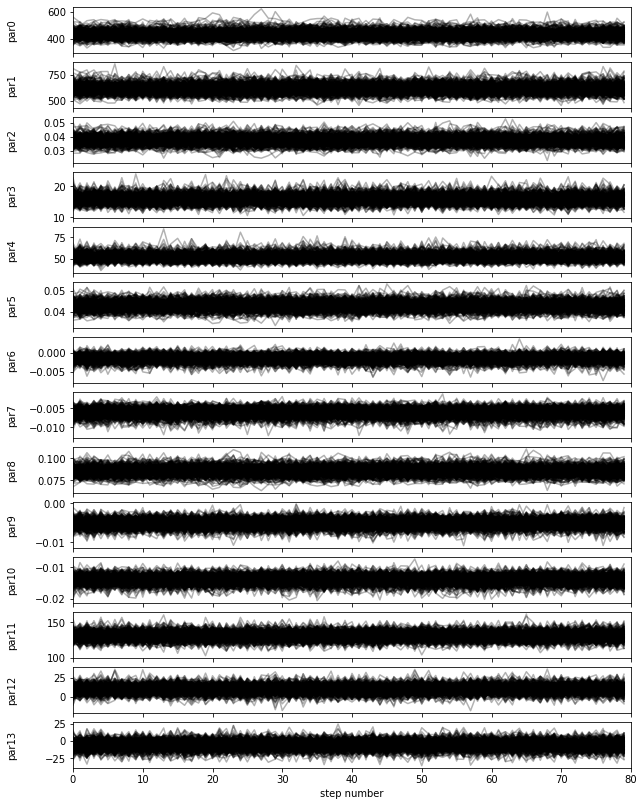

In [12]:
disp_n = 14
fig, axes = plt.subplots(disp_n, figsize=(10, 14), sharex=True)
labels = [f"par{i}" for i in range(disp_n)]

# each parameters number is corresponding to index of "param_names",
for i in range(disp_n):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


# Table 1. Estimated parameters of q-learning.

In [13]:
data = az.convert_to_inference_data(samples)
summary =az.summary(data, hdi_prob=0.95)
summary.index = param_names
display(summary)
for i in range(len(param_names)):
    summary.iloc[i]["mean"] = np.mean(samples[:,:,i])
#print(summary.to_csv())

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma2_r,433.462,33.113,371.190,499.485,0.211,0.149,24577.0,24577.0,24480.0,24333.0,1.0
sigma2_M,617.027,49.112,524.264,714.550,0.314,0.222,24391.0,24391.0,24341.0,23886.0,1.0
gamma,0.038,0.003,0.031,0.045,0.000,0.000,24455.0,24388.0,24420.0,24129.0,1.0
sigma2_X0,15.816,1.656,12.730,19.165,0.011,0.007,24692.0,24667.0,24706.0,24076.0,1.0
sigma2_Y0,52.144,4.908,43.089,61.955,0.031,0.022,24378.0,24378.0,24326.0,23915.0,1.0
alpha_X0,0.043,0.002,0.038,0.048,0.000,0.000,24491.0,24467.0,24499.0,24090.0,1.0
alpha_X_D5KO,-0.001,0.001,-0.004,0.001,0.000,0.000,24378.0,24378.0,24327.0,23756.0,1.0
alpha_X_male,-0.006,0.001,-0.009,-0.004,0.000,0.000,24240.0,24240.0,24232.0,24089.0,1.0
alpha_Y0,0.086,0.006,0.075,0.097,0.000,0.000,24380.0,24320.0,24419.0,23842.0,1.0
alpha_Y_D5KO,-0.005,0.001,-0.008,-0.003,0.000,0.000,24576.0,24576.0,24568.0,24435.0,1.0


# Figure ?. Simulated distributions from estimated parameters.

In [14]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=True
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'


In [15]:
def sim_result(init_dict, tp, sex, n_step):
    d = q_learning.set_type_sex_effect(init_dict,tp,sex,5,4,6)
    sim = q_learning.Simulation(d)

    sim.start(n_step)
    sim.vis_specific_index(n_step-1, title=f"{tp}_{sex}")
    

In [16]:
init_dict = {k:v for k,v in zip(summary.index, summary["mean"])}
n_iter = 100
n_step = 900
d = q_learning.set_type_sex_effect(init_dict,tp,sex,5,4,6)
base = np.ndarray(shape=(n_iter,200))

dists = {v:base.copy() for v in ["P_exp", "P_non_reward", "P_conf", "P_choice", "P_suv"]}
for i in range(n_iter):
    sim = q_learning.Simulation(d)
    sim.start(n_step)
    sim.vis_specific_index(n_step-1, show=False)
    for k,v in dists.items():
        dists[k][i] = getattr(sim.core, k)

In [17]:
dist_types = {}
for tp in ["D5KO", "wt"]:
    for sex in ["male", "female"]:
        kargs = dict(tp=tp, sex=sex, t_M=5, mu_X0=7, mu_Y0=3)
        dist_types[f"{tp}_{sex}"] = q_utils.sim_distribution_results(init_dict, n_iter=n_iter,n_step=n_step,**kargs)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


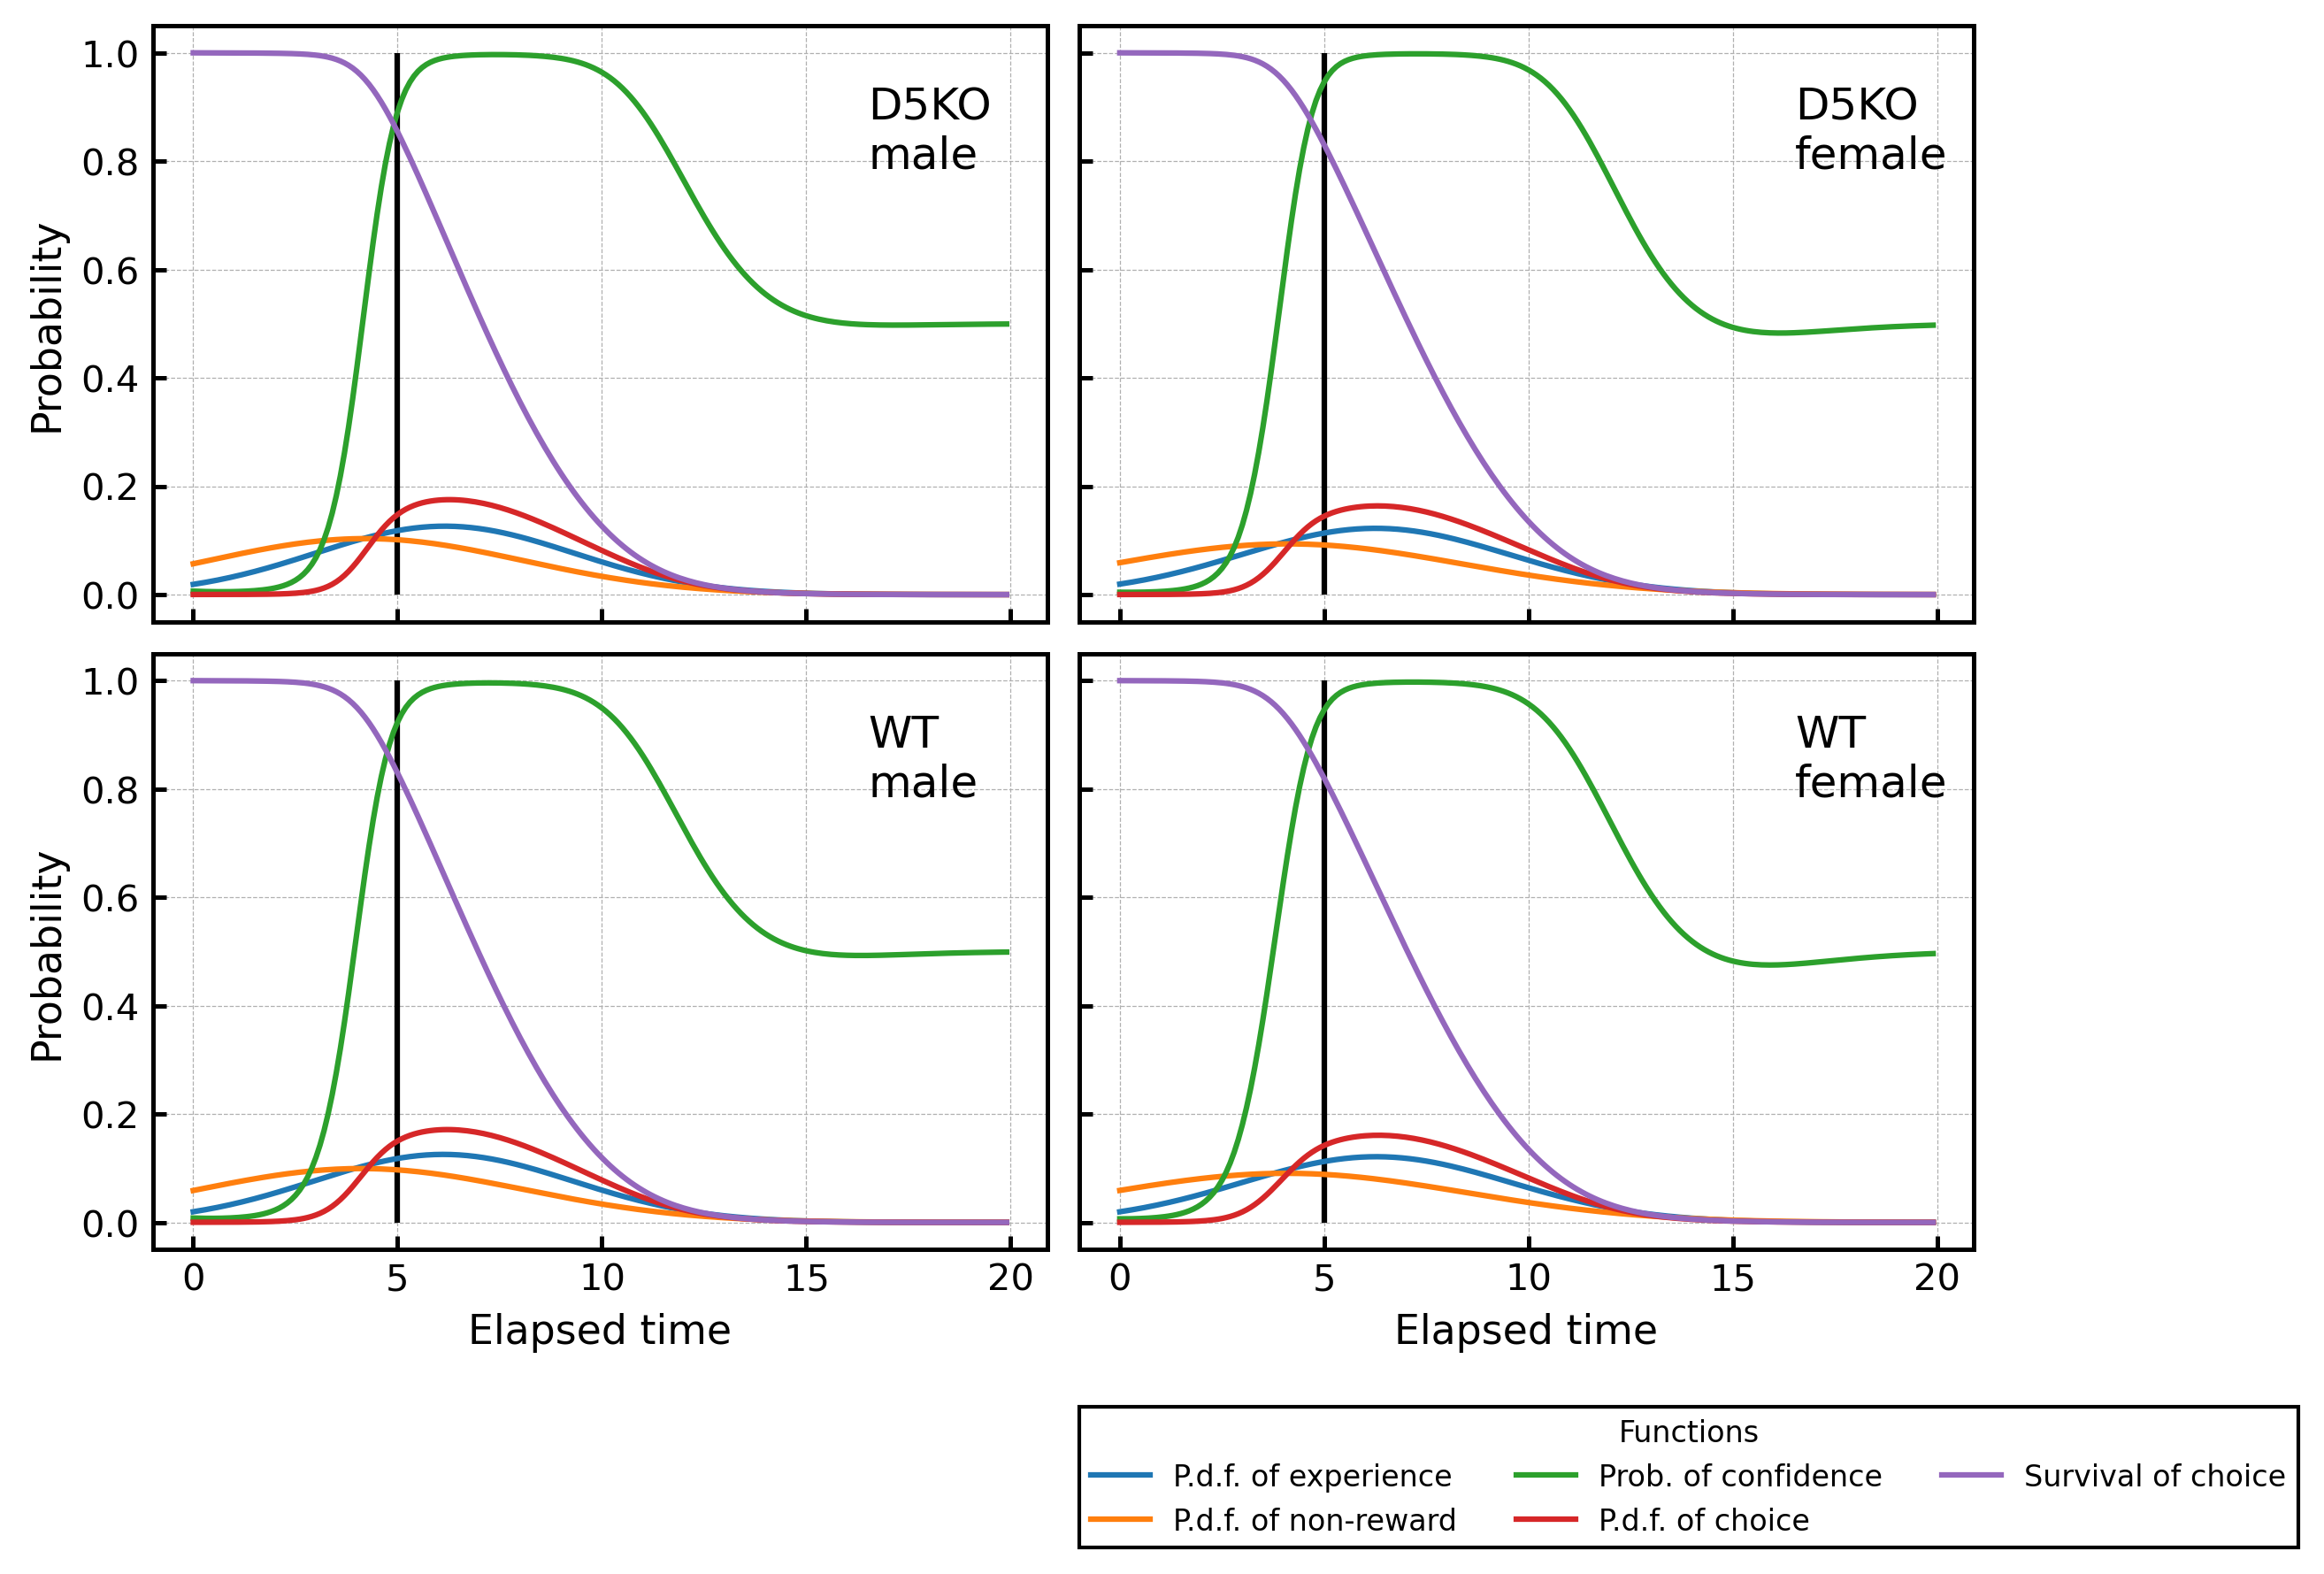

Figure legend should be modified using GIMP. 


In [18]:
label_names = ['P.d.f. of experience', 'P.d.f. of non-reward', 'Prob. of confidence', 
                   'P.d.f. of choice', 'Survival of choice']
dist_keys = ["P_exp", "P_non_reward", "P_conf", "P_choice", "P_suv"]
patches = visTools.create_patch_for_label(label_names = label_names, line=True)

with cplt.Multiple(figsize=(9,6),grid=(2,2),dpi=300, label_outer=True, 
                   save_path = "../dt_figs/Figure2_estimated_params.png",
                   savefig_kargs = dict(facecolor="white"),
                   tight=True 
                  ) as p:
    for i, (tp, sex) in enumerate(zip(["D5KO","D5KO","wt","wt"], ["male", "female", "male", "female"])):
        key = f"{tp}_{sex}"
        ax = p.set_ax(i + 1)
        ax.set_ylabel("Probability", fontsize=11)
        ax.set_xlabel("Elapsed time", fontsize=11)
        for k in dist_keys:
            ax.plot(sim.core.t_dist[:-1], dist_types[key][k].mean(axis=0))
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        tp_disp = "D5KO" if tp == "D5KO" else "WT"
        sex_disp = "male" if sex == "male" else "female"
        key_disp = f"{tp_disp}\n{sex_disp}"
        ax.text(0.8,0.9, key_disp, transform=ax.transAxes, va="top", ha="left", fontsize=12)
        #plt.legend()
        ax.vlines(x=5, ymin=0, ymax=1, color="black")
        
        if i == 3:
            plt.legend(loc=(0,-0.5),handles=patches, frameon=True, title="Functions", ncol=3)
            
print("Figure legend should be modified using GIMP. ")

# Table 2. Proportions of premature trials. 
- Average number of sessions for each data. 
- Average proportion of premature for each data. 
- Calculate proportion of premature for simulational data.

In [19]:
df = q_utils.read_total_time_data(pL.merged_structured_df, q_utils.CaseParams.valid_mice)
data_dic = q_utils.convert_data_to_pymc3_dict(df, q_utils.CaseParams.valid_mice)
n = len(data_dic.keys())

In [20]:
keys = data_dic.keys()
cnt_dic = {}
pre_dic = {}

for i, (tp, sex) in enumerate(zip(["D5KO","D5KO","wt","wt"], ["male", "female", "male", "female"])):
    sum_key = f"{tp}_{sex}"
    df_cnt = pd.DataFrame()
    df_pre = pd.DataFrame()
    for k in keys:
        if not ( (data_dic[k]["type"] == tp) & (data_dic[k]["sex"] == sex)):
            continue
        dfM = data_dic[k]["data"]
        dfM["count"] = 1
        vals = dfM["session_index"].value_counts(dropna=False)
        vals.name = k
        df_cnt = pd.concat((df_cnt, vals), axis=1)

        vals_pre = dfM.groupby("session_index")['premature_reseponse_tag'].sum()
        vals_pre.name = k
        df_pre = pd.concat((df_pre, vals_pre), axis=1)
    cnt_dic[sum_key] = df_cnt
    pre_dic[sum_key] = df_pre
    # print(sum_key, df_cnt.shape)
    
# print("Mean of each session")
# display(df_cnt.mean(axis=1))
# print("="*30)
# print("Mean of all session")
# display(df_cnt.mean(axis=1).mean())

In [21]:
sum_dic = {}
for k in pre_dic.keys():
    sum_dic[k] = pre_dic[k].mean(axis=1)
sum_df = pd.DataFrame(sum_dic).round(2)
print("Percentage of premature from real trial data\n")
display(sum_df)
#print(sum_df.to_csv())

Percentage of premature from real trial data



,D5KO_male,D5KO_female,wt_male,wt_female
1,29.73,32.2,30.93,33.36
2,39.09,37.1,32.14,35.45
3,27.73,24.7,35.14,38.00
4,29.91,23.0,27.00,34.64
5,20.64,21.3,32.71,29.09
6,22.09,15.9,23.50,24.73
7,29.55,36.7,21.21,22.73
8,25.82,22.1,29.79,15.91
9,21.82,26.1,18.86,13.36
10,14.45,20.1,19.64,11.27


## For simulated data

In [22]:
n_one = 90
sim_real_set =  [ sim.t_real[i*n_one :(i+1)*n_one ]  for i in range(9)]
sim_per = [ (np.array(s) < 5).sum() for s in sim_real_set]

In [23]:
per_dic = {}
for i, (tp, sex) in enumerate(zip(["D5KO","D5KO","wt","wt"], ["male", "female", "male", "female"])):
    key = f"{tp}_{sex}"
    per_dic[key] = []
    for i in range(10):
        one = np.array(dist_types[key]["t_real"])[:, i*n_one:(i+1)*n_one]
        one_bool = one < 5
        per_dic[key].append(one_bool.mean(axis=1).mean()*100)
per_df =  pd.DataFrame(per_dic).round(2)

In [24]:
print("Percentage of premature from simulated data\n")
display(per_df)
print(per_df.to_csv())

Percentage of premature from simulated data



,D5KO_male,D5KO_female,wt_male,wt_female
0,25.70,25.50,26.30,25.46
1,14.93,16.43,15.84,16.88
2,11.94,15.01,14.93,16.58
3,12.57,15.41,15.40,16.52
4,12.42,14.93,15.04,16.88
5,13.16,15.40,14.68,17.13
6,13.44,15.10,14.61,15.83
7,13.44,15.44,15.74,16.83
8,12.13,16.42,15.38,16.16
9,12.38,15.29,14.81,15.87


,D5KO_male,D5KO_female,wt_male,wt_female
0,25.7,25.5,26.3,25.46
1,14.93,16.43,15.84,16.88
2,11.94,15.01,14.93,16.58
3,12.57,15.41,15.4,16.52
4,12.42,14.93,15.04,16.88
5,13.16,15.4,14.68,17.13
6,13.44,15.1,14.61,15.83
7,13.44,15.44,15.74,16.83
8,12.13,16.42,15.38,16.16
9,12.38,15.29,14.81,15.87



# Figure S1. Scatter plot of simulated and real trials for each genomic and sex type.

In [25]:
df = q_utils.read_total_time_data(pL.merged_structured_df, q_utils.CaseParams.valid_mice)
subjects = df["subject"].unique()

In [26]:
for subject in subjects:
    q_utils.individual_fitting(df, subject, till=10)

In [27]:
data = q_utils.load_fitted_data(subjects, till=10)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


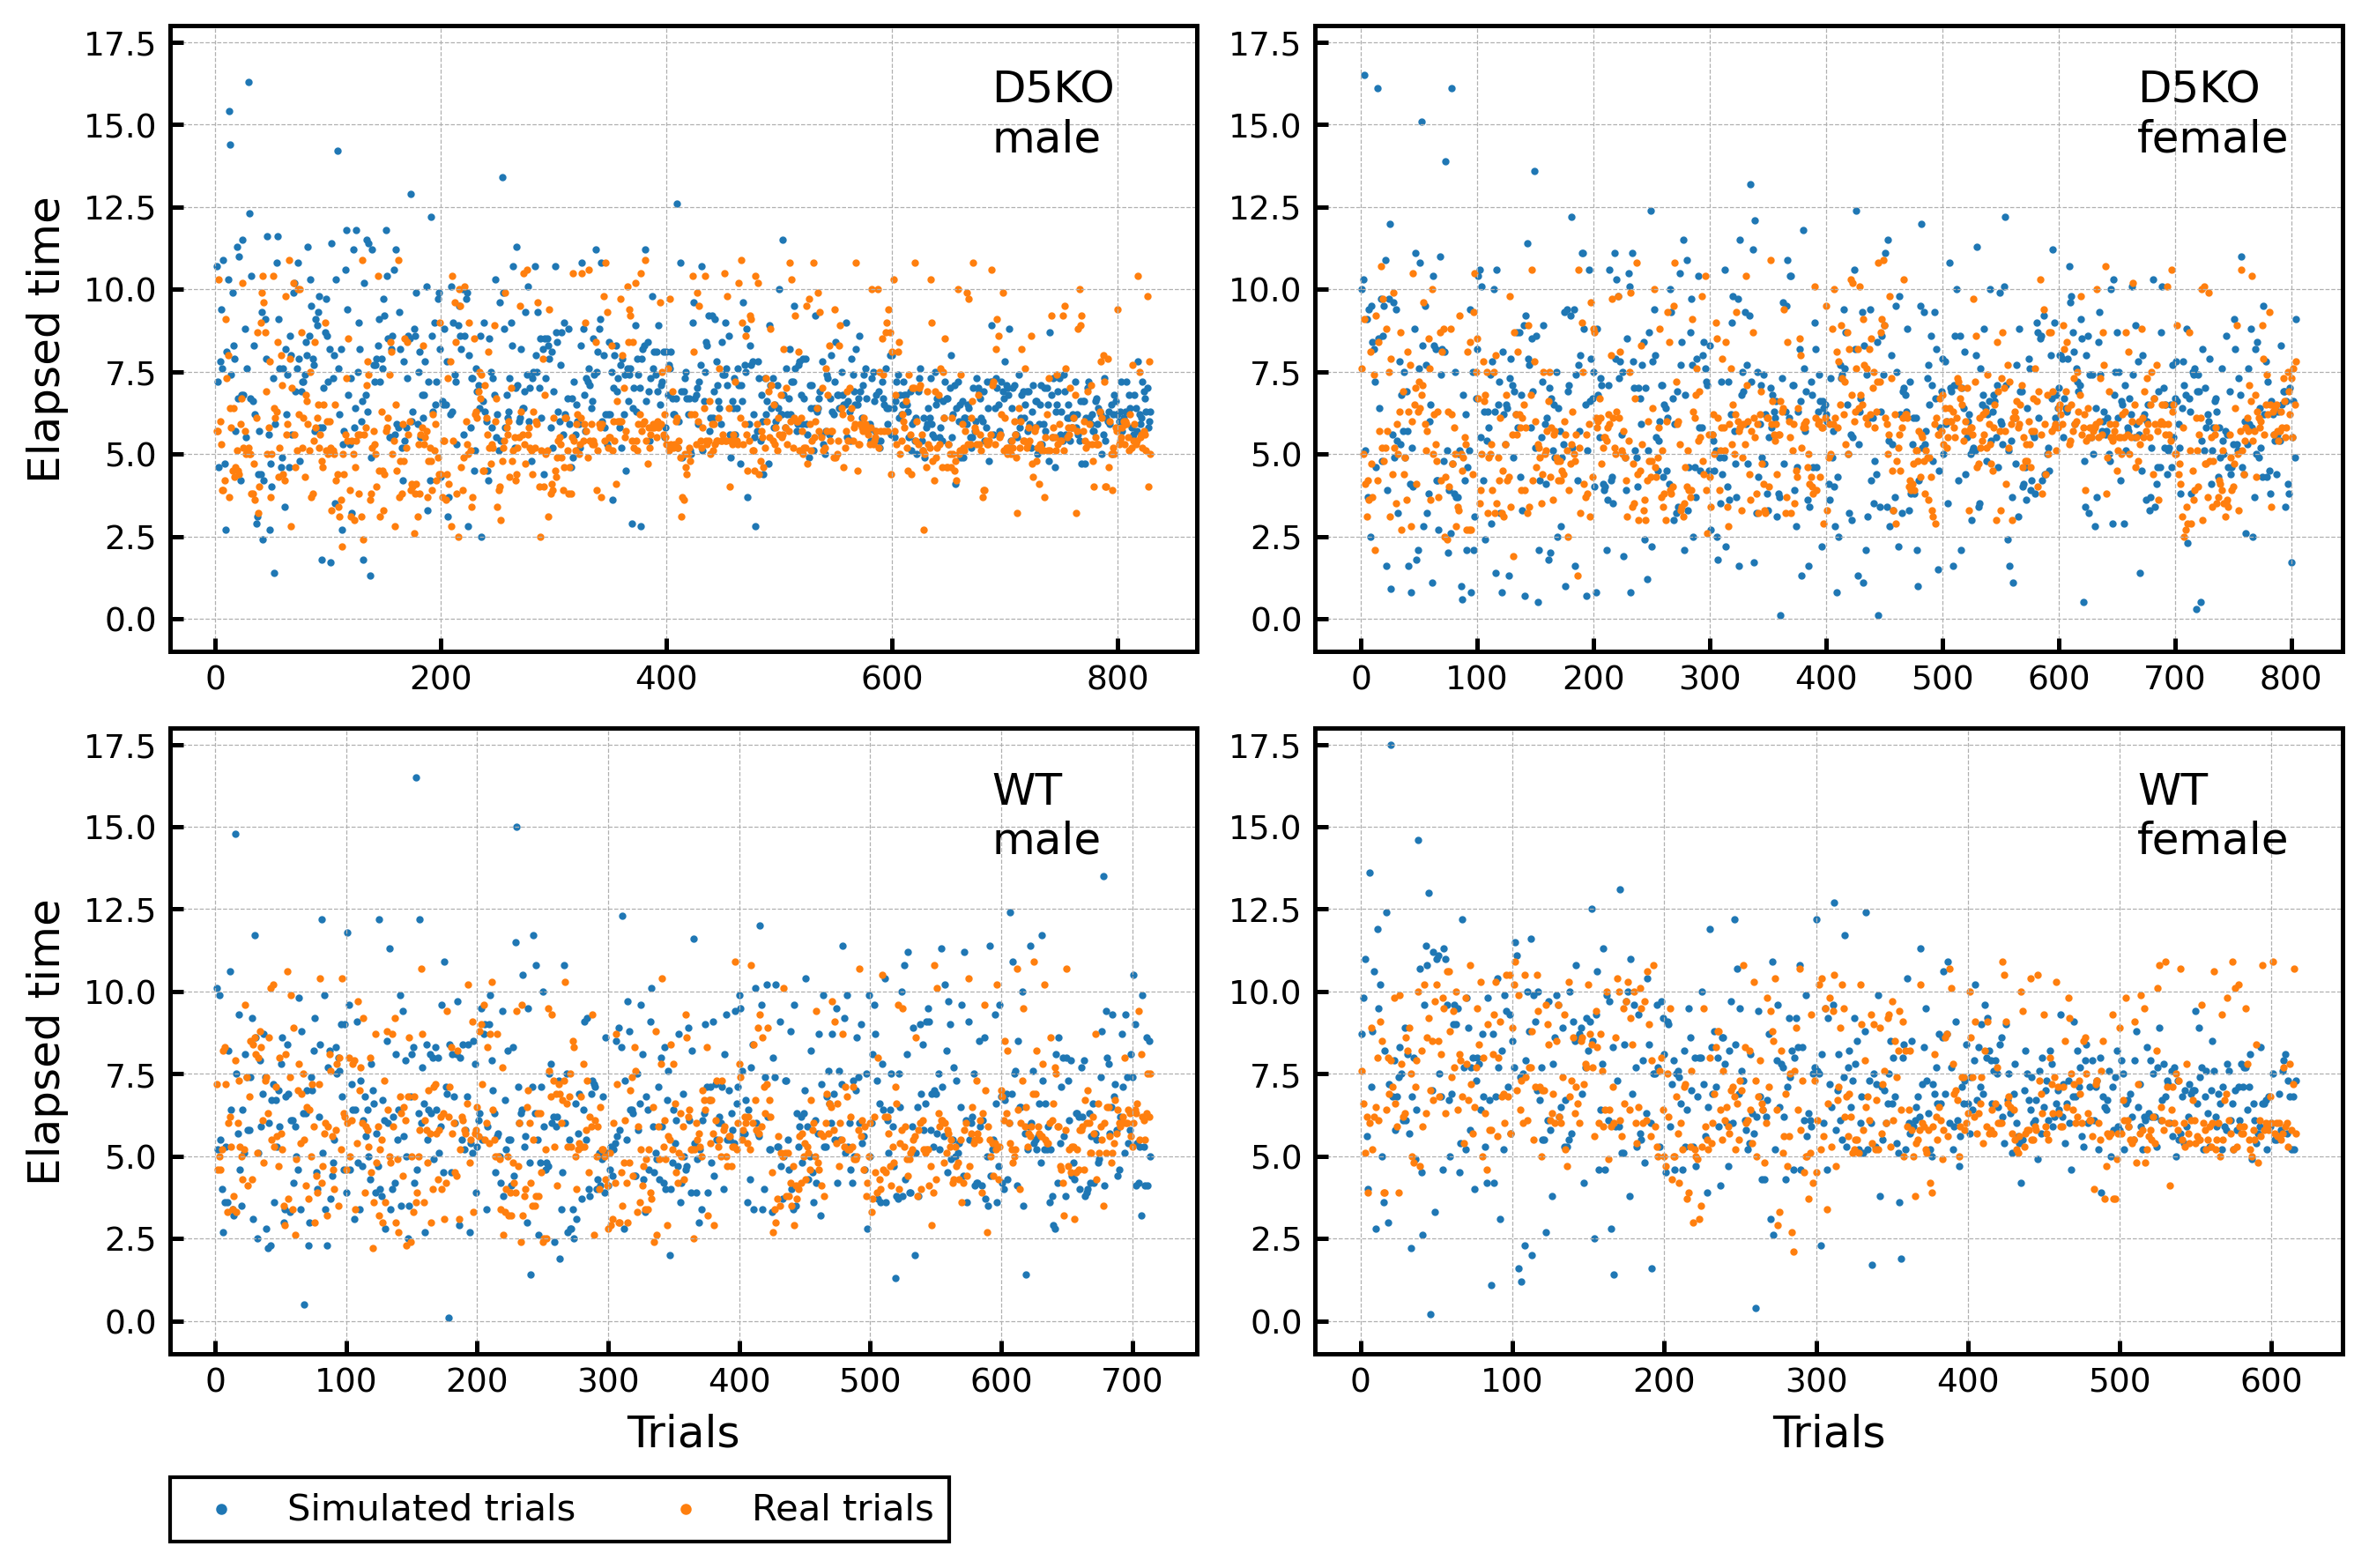

In [28]:
champions = {
    "D5KO\nmale":"D281", 
    "D5KO\nfemale": "D141",
    "WT\nmale": "D363", 
    "WT\nfemale": "D199", 
        }

#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
#sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

with cplt.Multiple(figsize=(9,6),grid=(2,2),dpi=300, 
                  save_path = "../dt_figs/S_Fig1_champions.tiff",
                  savefig_kargs = dict(facecolor="white",pil_kwargs={"compression": "tiff_lzw"}), 
                  ) as p:
    for i, (label, sub) in enumerate(champions.items()):
        d = None
        for d_ in data:
            if d_["subject"] == sub:
                d = d_
        cond = df["subject"] == d["subject"]
        dfM = df.loc[cond]
        fit_res, values = q_utils.simulate_one_from_fitted_res(d, dfM)
        ind = [j+1 for j in range(len(values))]
        
        ax = p.set_ax(i+1, ylim=[-1,18])
        ax.scatter(ind, fit_res.sim.t_real, s=1, label="Simulated trials" )
        ax.scatter(ind, values, s=1, label="Real trials")
        ax.text(0.8,0.8, label, transform=ax.transAxes, fontsize=12)
        
        ax.tick_params(axis='both', which='major', labelsize=9)
        
        if i >1 :
            ax.set_xlabel("Trials", fontsize=12)
        if i % 2 == 0:
            ax.set_ylabel("Elapsed time", fontsize=12)
        if i == 2:
            plt.legend(loc=(0.0,-0.30), frameon=True,  ncol=2, fontsize=10)
            
        #plt.legend()

# Figure ??. Methodology

In [29]:
init_params = {'sigma2_r': 400, 'sigma2_M': 600, 'alpha_X': 0.04,
               'alpha_Y': 0.08, 'beta': 130, 'gamma': 0.04, 't_M': 5, 
               'mu_X0': 7, 'sigma2_X0': 15, 'mu_Y0': 4, 'sigma2_Y0': 50
              }

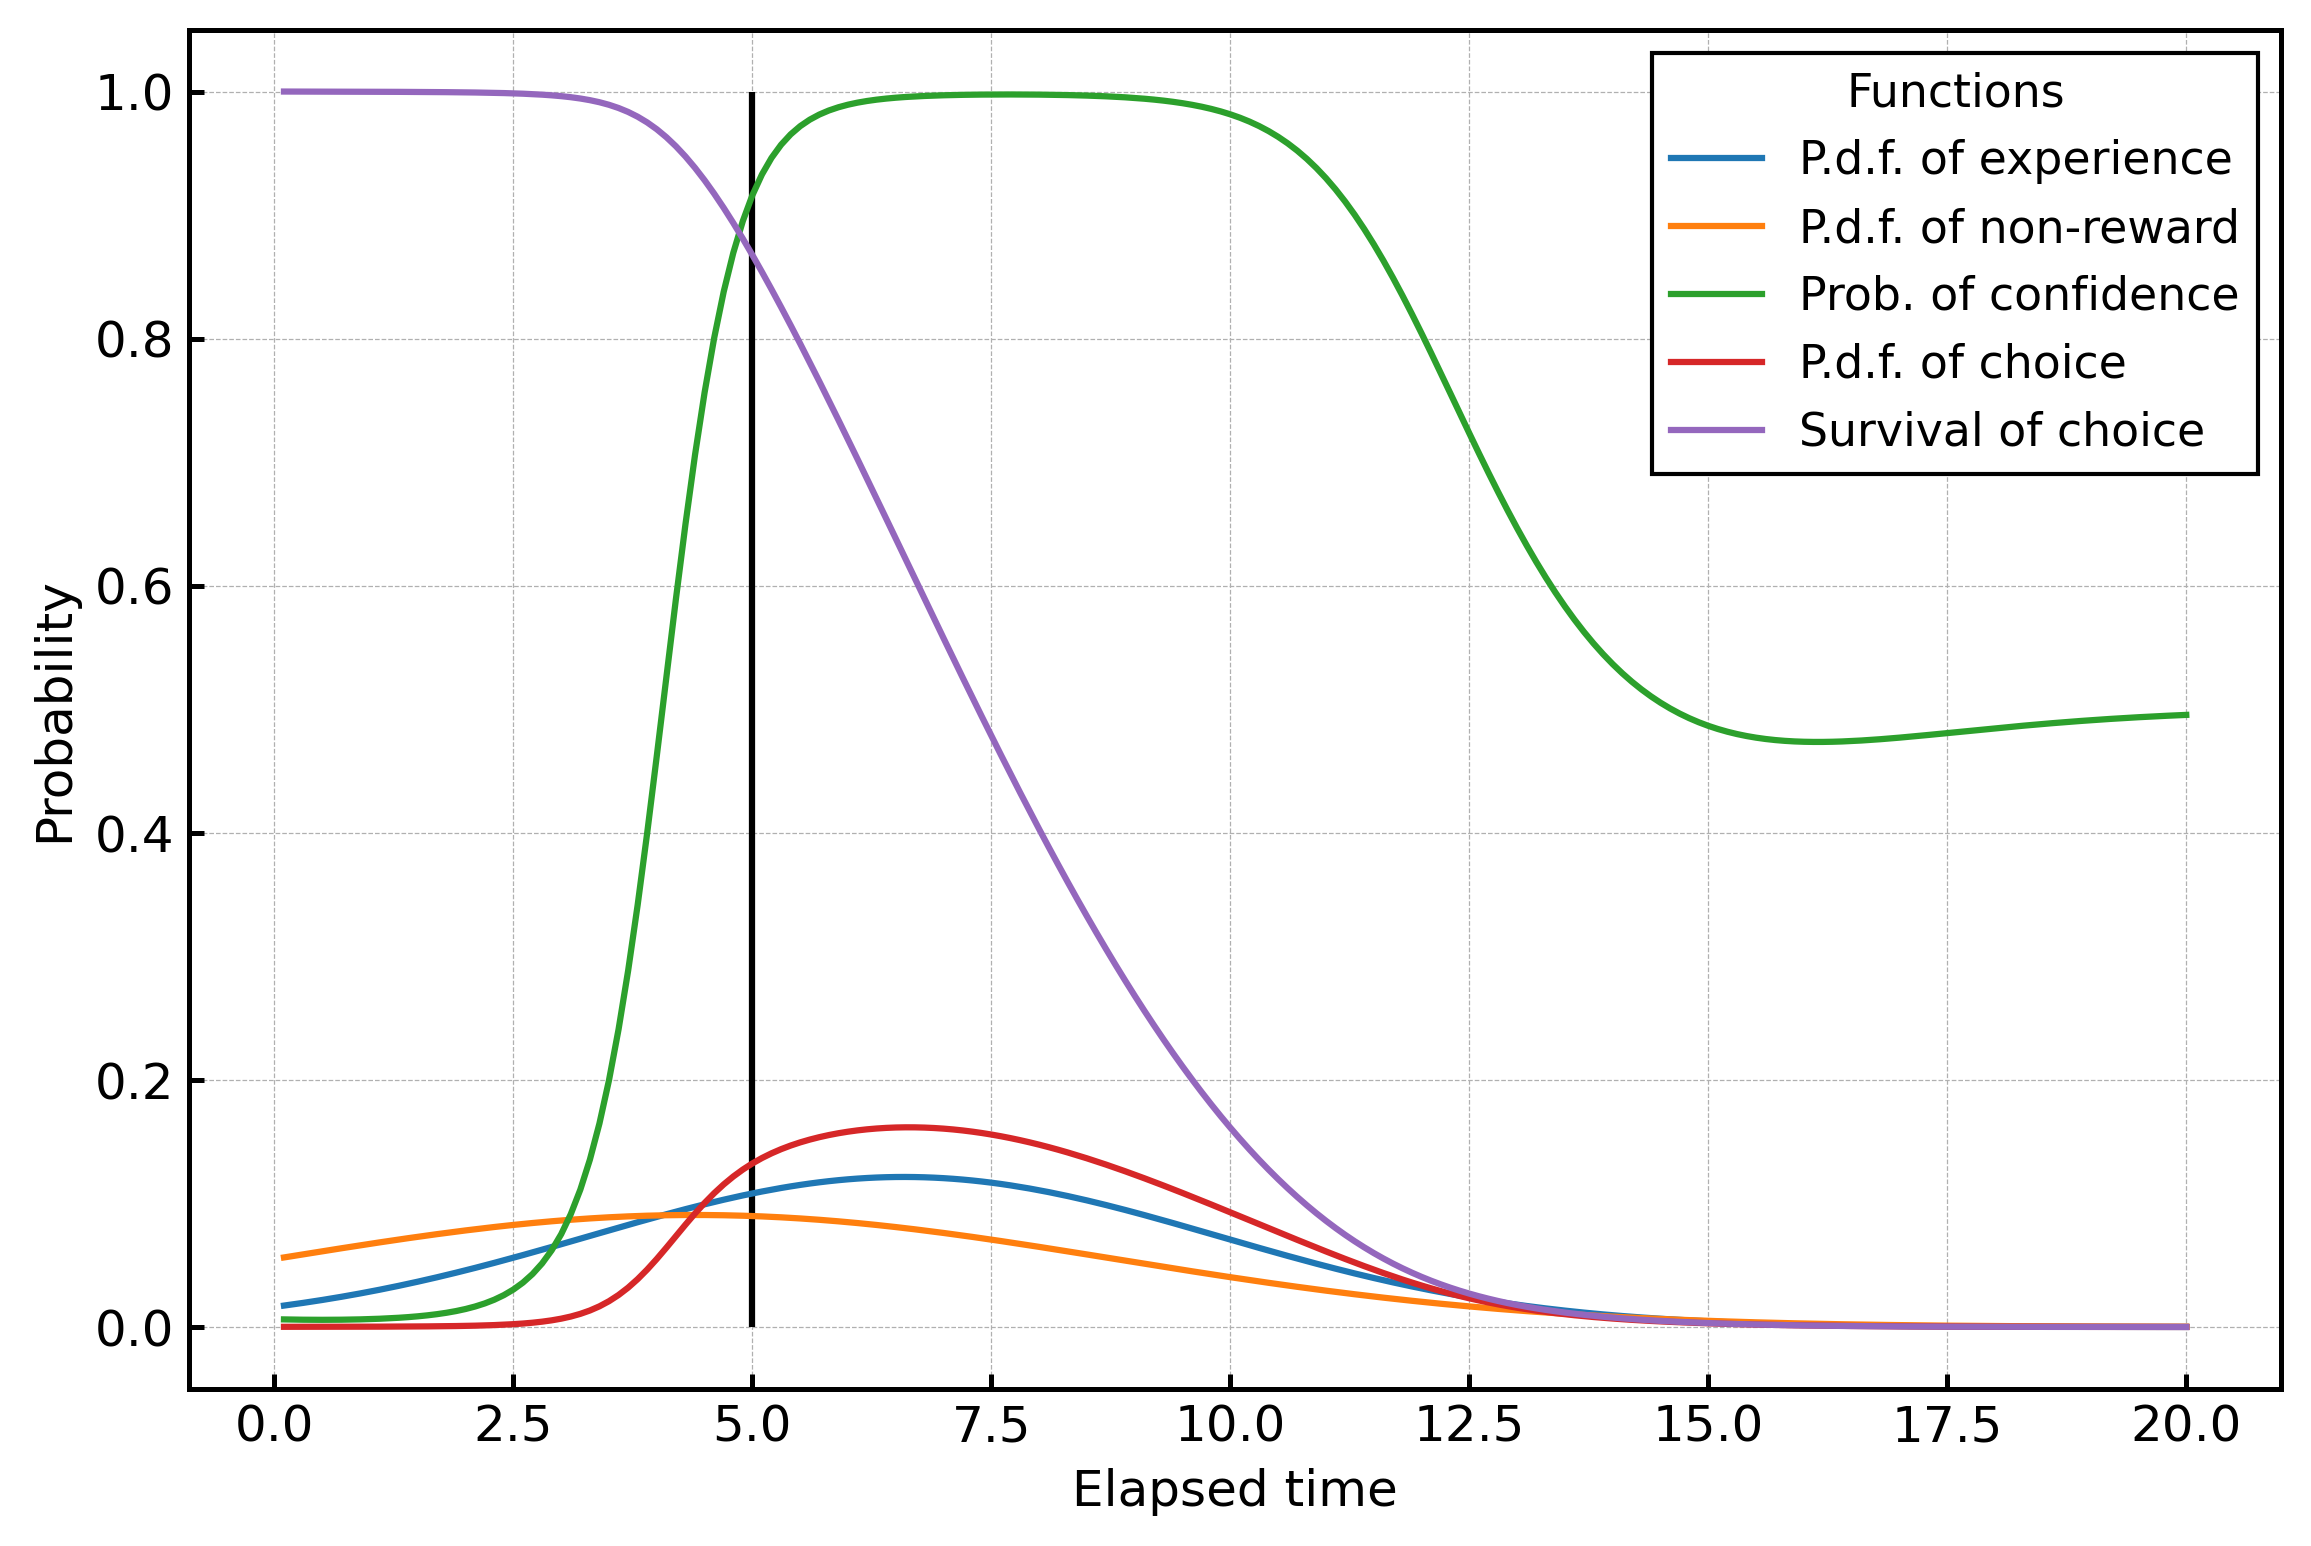

In [30]:
t = sim.core.t_dist.copy()
t.pop(0)
core = sim.core
fig = plt.figure(figsize=(9,6),dpi=300)
ax = fig.add_subplot(111)

ax.set_xlabel("Elapsed time", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)

ax.plot(t, core.P_exp, label="P.d.f. of experience") 
ax.plot(t, core.P_non_reward, label="P.d.f. of non-reward")
ax.plot(t, core.P_conf, label="Prob. of confidence")
ax.plot(t, core.P_choice, label="P.d.f. of choice")
ax.plot(t, core.P_suv, label="Survival of choice")
ax.vlines(x = 5,ymin=0,ymax=1, color="black")
ax.tick_params(axis='both', which='major', labelsize=12)
lgd = plt.legend(title="Functions", fontsize=11)
lgd.get_title().set_fontsize('11') 
plt.savefig("../dt_figs/Fig1_methodology.tiff", facecolor="white", pil_kwargs={"compression": "tiff_lzw"})